## **Predictive modeling - Linear Regression model (Daily mean tempreture - Kandy)**

In here we removed highly correlated features [shortwave_radiation and max_wind_gust] & outliers

In [167]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
import statsmodels.formula.api as smf

In [168]:
kandy_weather = pd.read_csv('../data/processed/kandy_weather_no_outliers.csv')

In [169]:
#drop highly correlated columns 
kandy_weather = kandy_weather.drop(columns=['max_temperature', 'min_temperature', 'apparent_temperature_mean', 'shortwave_radiation', 'max_wind_gust'])

In [170]:
kandy_weather

,time,weathercode,mean_temperature,rainfall,max_wind_speed,dominant_Wind_Direction,evapotranspiration,rain_tomorrow,year,month,day
0,2010-01-01,2,22.0,0.0,15.3,57,3.43,0,2010,1,1
1,2010-01-02,2,22.2,0.0,13.3,46,2.95,1,2010,1,2
2,2010-01-03,51,22.1,0.1,10.7,40,2.84,1,2010,1,3
3,2010-01-04,51,21.9,0.6,10.4,23,3.16,0,2010,1,4
4,2010-01-08,51,22.5,0.8,9.4,326,2.33,1,2010,1,8
...,...,...,...,...,...,...,...,...,...,...,...
3819,2023-06-13,53,24.0,3.1,16.6,221,3.51,1,2023,6,13
3820,2023-06-14,53,24.4,4.0,16.8,218,3.56,1,2023,6,14
3821,2023-06-15,51,24.7,0.6,14.2,217,3.53,1,2023,6,15
3822,2023-06-16,53,24.6,1.9,17.9,224,4.09,1,2023,6,16


In [171]:
print(kandy_weather.columns.tolist())


['time', 'weathercode', 'mean_temperature', 'rainfall', 'max_wind_speed', 'dominant_Wind_Direction', 'evapotranspiration', 'rain_tomorrow', 'year', 'month', 'day']


In [172]:
numerical_vars = ['rainfall', 'max_wind_speed', 'dominant_Wind_Direction', 'evapotranspiration', 'rain_tomorrow', 'month']
categorical_vars = ['weathercode']
target = 'mean_temperature'

# Features and target (raw, do not dummy encode yet)
x = kandy_weather[categorical_vars + numerical_vars]
y = kandy_weather[target]

# Train/test split (chronological)
train_set = kandy_weather[kandy_weather['year'] <= 2018]
validation_set = kandy_weather[kandy_weather['year'] == 2019]
test_set = kandy_weather[kandy_weather['year'] >= 2020]

train_end = len(train_set)
val_end = train_end + len(validation_set)

x_train, y_train = x.iloc[:train_end], y.iloc[:train_end]
x_val, y_val = x.iloc[train_end:val_end], y.iloc[train_end:val_end]
x_test, y_test = x.iloc[val_end:], y.iloc[val_end:]

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first'), categorical_vars),          # one-hot encode categorical
    ('num', StandardScaler(), numerical_vars)                        # scale numerical
])

pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', LinearRegression())
])

pipeline.fit(x_train, y_train)


,steps,"[('preprocessing', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [173]:
# Get feature names after preprocessing
feature_names = pipeline.named_steps['preprocessing'].get_feature_names_out()

# Get coefficients and intercept
coefs = pipeline.named_steps['model'].coef_
intercept = pipeline.named_steps['model'].intercept_

# Combine into DataFrame
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefs
})

print(f'intercept : {intercept}')

print(coef_df)


intercept : 22.515354863855695
                         Feature  Coefficient
0             cat__weathercode_1     0.378886
1             cat__weathercode_2     0.660261
2             cat__weathercode_3     0.900200
3            cat__weathercode_51     1.170614
4            cat__weathercode_53     1.265024
5            cat__weathercode_55     1.241594
6            cat__weathercode_61     1.286179
7            cat__weathercode_63     1.356190
8            cat__weathercode_65     0.862667
9                  num__rainfall    -0.077174
10           num__max_wind_speed    -0.118513
11  num__dominant_Wind_Direction     0.167760
12       num__evapotranspiration     0.596875
13            num__rain_tomorrow     0.106822
14                    num__month    -0.129939


In [174]:
def evaluate_model(pipeline, X, y, dataset_name):
    """Evaluate model performance"""
    predictions = pipeline.predict(X)
    
    mse = mean_squared_error(y, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y, predictions)
    r2 = r2_score(y, predictions)
    
    print(f"\n{dataset_name} Set Performance:")
    print(f"  RMSE: {rmse:.4f}°C")
    print(f"  MAE:  {mae:.4f}°C")
    print(f"  R²:   {r2:.4f}")
    
    return predictions, {'RMSE': rmse, 'MAE': mae, 'R2': r2}

# Evaluate on all sets
train_pred, train_metrics = evaluate_model(pipeline, x_train, y_train, "Training")
val_pred, val_metrics = evaluate_model(pipeline, x_val, y_val, "Validation")
test_pred, test_metrics = evaluate_model(pipeline, x_test, y_test, "Test")


Training Set Performance:
  RMSE: 0.5450°C
  MAE:  0.4312°C
  R²:   0.6091

Validation Set Performance:
  RMSE: 0.6895°C
  MAE:  0.5530°C
  R²:   0.4874

Test Set Performance:
  RMSE: 0.5796°C
  MAE:  0.4727°C
  R²:   0.5903


In [175]:
y_pred = pipeline.predict(x_test)

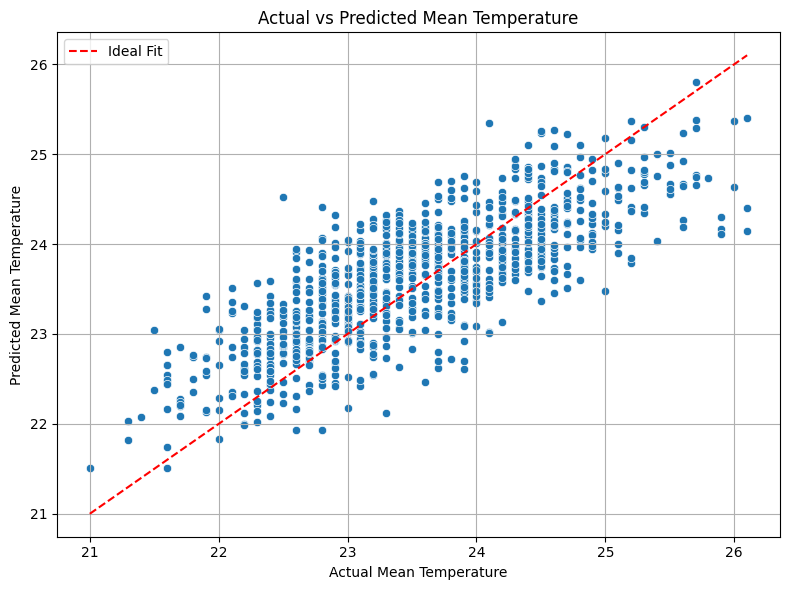

In [176]:
# Scatter plot: Actual vs Predicted
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Ideal Fit')
plt.xlabel('Actual Mean Temperature')
plt.ylabel('Predicted Mean Temperature')
plt.title('Actual vs Predicted Mean Temperature')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [177]:
# --- Combine training data for statsmodels ---
train_data = x_train.copy()
train_data['mean_temperature'] = y_train

scaler = StandardScaler()
train_scaled = train_data.copy()
train_scaled[numerical_vars] = scaler.fit_transform(train_scaled[numerical_vars])

# --- Build the regression formula ---
formula = "mean_temperature ~ C(weathercode) + rainfall + max_wind_speed + dominant_Wind_Direction + evapotranspiration + rain_tomorrow + month"

# --- Fit the OLS regression model ---
model = smf.ols(formula=formula, data=train_scaled).fit()

# --- Print full model summary ---
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:       mean_temperature   R-squared:                       0.609
Model:                            OLS   Adj. R-squared:                  0.607
Method:                 Least Squares   F-statistic:                     262.0
Date:                Thu, 18 Sep 2025   Prob (F-statistic):               0.00
Time:                        20:37:19   Log-Likelihood:                -2061.4
No. Observations:                2539   AIC:                             4155.
Df Residuals:                    2523   BIC:                             4248.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

### **Residuals Analysis**

In [178]:
residuals = y_test - y_pred

#### **Normality of errors**

In [179]:
from statsmodels.stats.stattools import durbin_watson

dw_stat = durbin_watson(residuals)
print(f"Durbin–Watson Statistic: {dw_stat:.4f}")

Durbin–Watson Statistic: 0.5439


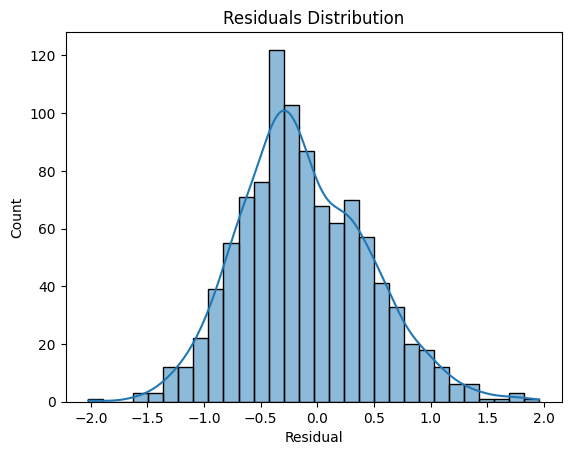

In [180]:
sns.histplot(residuals, bins=30, kde=True)
plt.title("Residuals Distribution")
plt.xlabel("Residual")
plt.show()


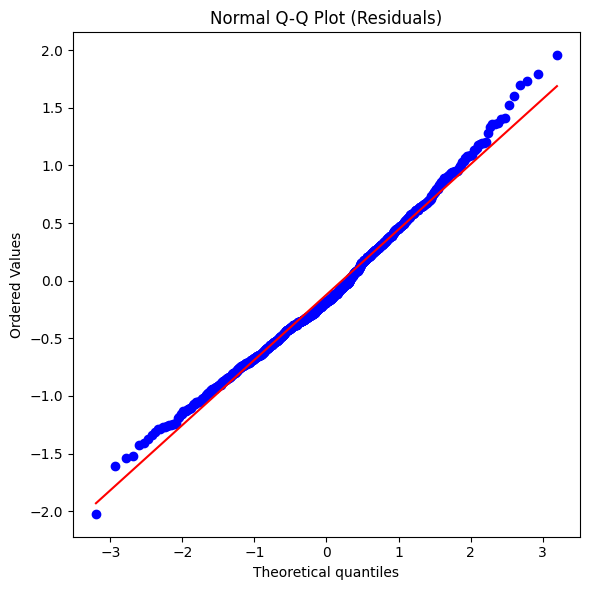

In [181]:
from scipy.stats import probplot

plt.figure(figsize=(6, 6))
probplot(residuals, dist="norm", plot=plt)
plt.title('Normal Q-Q Plot (Residuals)')
plt.tight_layout()
plt.show()

In [182]:
from scipy.stats import shapiro
stat, p = shapiro(residuals)
print("Shapiro-Wilk Test: stat=%.3f, p=%.3f" % (stat, p))

Shapiro-Wilk Test: stat=0.992, p=0.000


#### **Homoscedasticity**

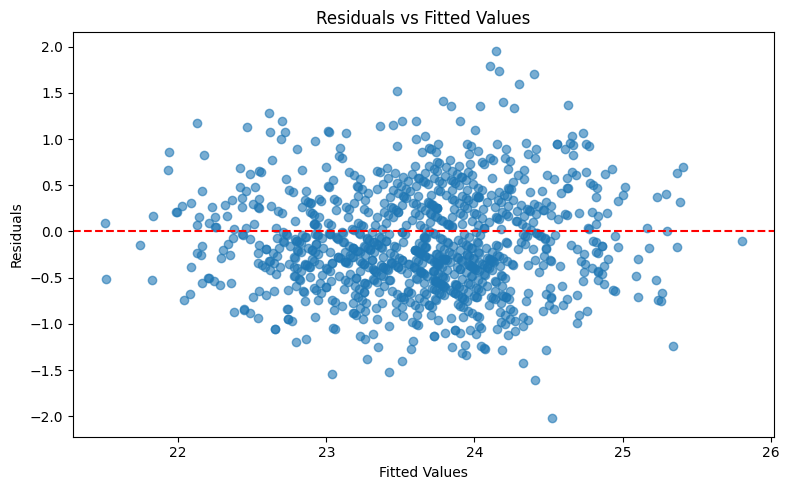

In [183]:
plt.figure(figsize=(8, 5))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted Values")
plt.tight_layout()
plt.show()

Outstanding Random Distribution

    Perfect random scatter around the zero line (red dashed line)
    No systematic patterns, curves, or trends visible
    Strong evidence that linear model assumptions are well satisfied


Excellent Homoscedasticity

    Very consistent variance across all fitted values (22-26°C)
    No funnel shapes or variance changes
    Model maintains stable prediction accuracy across temperature range


Well-Balanced Residuals

    Residuals symmetrically distributed above and below zero
    No bias in model predictions


Improved Outlier Control

    Most extreme residuals now within ±2°C range
    Much better than previous versions showing ±3-4°C extremes
    Suggests effective outlier treatment or model improvement

In [184]:
from statsmodels.stats.diagnostic import het_breuschpagan

# Requires residuals & design matrix
import statsmodels.api as sm
exog = sm.add_constant(x_test)  # add intercept
bp_test = het_breuschpagan(residuals, exog)

print("\n--- Breusch-Pagan Test ---")
print(f"Test Statistic: {bp_test[0]:.4f}")
print(f"p-value       : {bp_test[1]:.4f}")



--- Breusch-Pagan Test ---
Test Statistic: 40.9390
p-value       : 0.0000


### **Multicollinearity: VIF**

In [185]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd
import numpy as np

# --- One-hot encode categorical variables ---
X = pd.get_dummies(
    train_data[['weathercode', 'rainfall',
                'max_wind_speed',
                'dominant_Wind_Direction', 'evapotranspiration', 'rain_tomorrow' , 'month']],
    drop_first=True
)

# --- Ensure numeric dtype (convert bool -> int, etc.) ---
X = X.astype(float)

# --- Drop rows with NaNs if any ---
X = X.dropna()

# --- Calculate VIF ---
vif = pd.DataFrame()
vif["Feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)


                   Feature       VIF
0              weathercode  9.744065
1                 rainfall  2.976764
2           max_wind_speed  9.551104
3  dominant_Wind_Direction  7.469481
4       evapotranspiration  9.602374
5            rain_tomorrow  7.235476
6                    month  5.351925
